# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Apply a perspective transform to image ("birds-eye view").
4. Use color transforms, gradients, etc., to create a thresholded binary image.
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
9. Pipeline section
10. Video Output


## To Check overall picture of the project you can directly check the pipeline section that explain everything

### 1. compute the camera calibration using chessboard images

Here i used all the 9X6 chessboard images to obtain objects and image points.


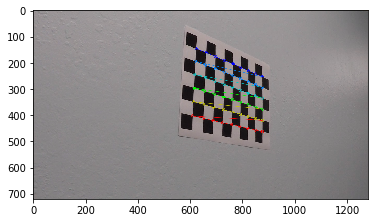

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,0,0),...(7,4,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        


#### undistort()
        function is used to undistort the distorted image
        
   Here i used `cv2.calibrateCamera` function to find the camera matrix and distortion coefficients
   And used `cv2.undistort` to undistort the distored image

In [2]:
def undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvec, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx,dist, None, mtx)
    
    return undist

### 2. Applying a distortion correction to all given test images

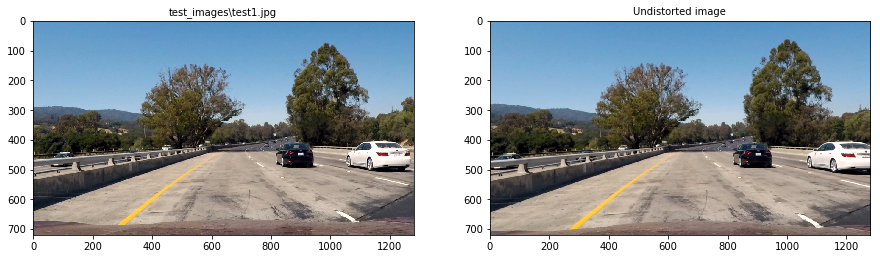

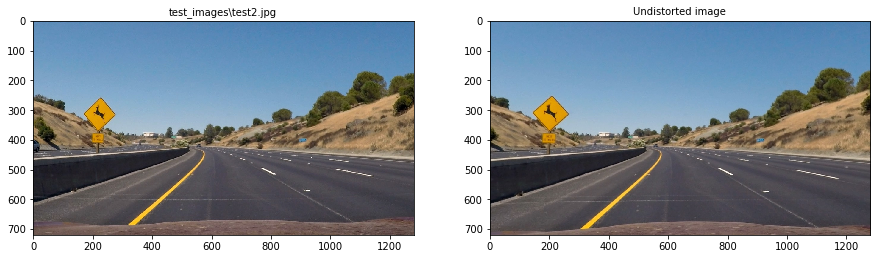

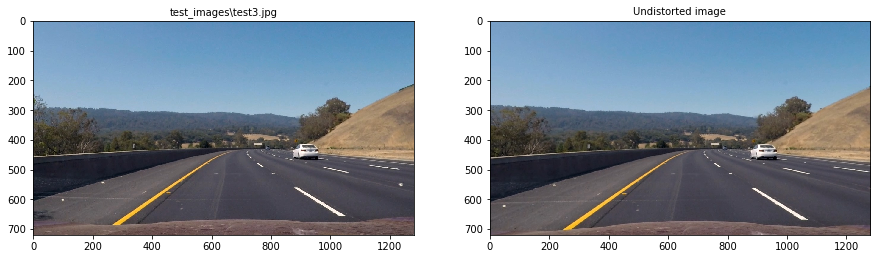

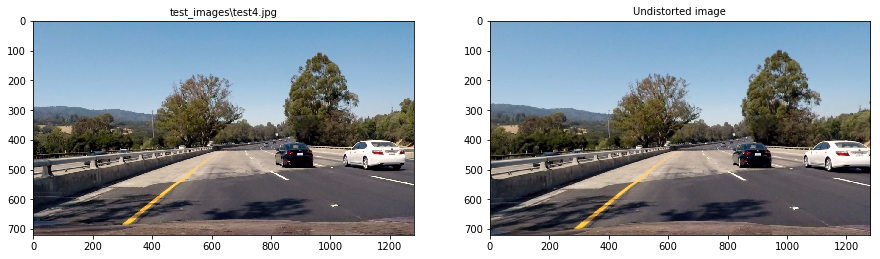

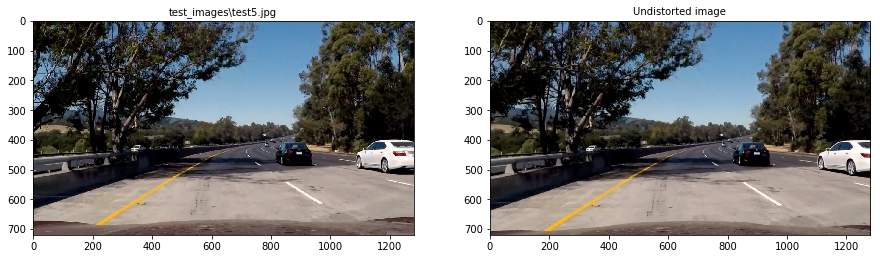

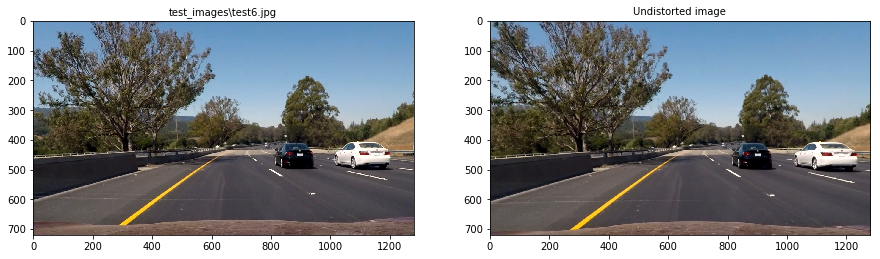

In [3]:
images = glob.glob('test_images/test*.jpg')

for image in images:
    img = mpimg.imread(image)
    undistimg = undistort(img,objpoints,imgpoints)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
    ax1.imshow(img)
    ax1.set_title(image, fontsize=10)
    ax2.imshow(undistimg)
    ax2.set_title('Undistorted image', fontsize=10)

### 3. Apply a perspective transform to image ("birds-eye view").

I changed the strategy from this point. Previously i was first converting the raw image into a binary threshold image then taking the perspective transform. But after lot of experiment in color spaces and gradient method. I didn't get satifactory result. The main problem with farther lane pixels in the image which are not identified when there is dark in image or too far.
So whenever we find binary threshold image result was not good. So i decided to first transform image in perspective view. Which gives all the lane pixel clearly in vertically distributed on the image. And after finding binary image result is also good.

Here i used below four source and destination points.
This i found from straight line image (straight_lines1.jpg) given in test_images folder

    imshape[0] = height of the image
    imshape[1] = width of the image

Source points:

    bottom_left = [0+130,imshape[0]]
    bottom_right = [imshape[1]-80,imshape[0]]
    top_left = [imshape[1]//2-85,imshape[0]//2+110]
    top_right = [imshape[1]//2+95,imshape[0]//2+110]

Destination points:

    bottom_left = [0+250,imshape[0]]
    bottom_right = [imshape[1]-300,imshape[0]]
    top_left = [0+250,0]
    top_right = [imshape[1]-300,0]]

#### warp()
        function is used to change the perspective of the image
        Here i am using this warp() function to convert image to warp birds-eye view image

In [4]:
def warp(img):
    
    imshape=img.shape
    img_size=(imshape[1],imshape[0])
    #Four source coordinate

    src = np.float32([
        [0+130,imshape[0]],
        [imshape[1]-80,imshape[0]],
        [imshape[1]//2-85,imshape[0]//2+110],
        [imshape[1]//2+95,imshape[0]//2+110]])
       
    #Four dst coordinate
    dst = np.float32([
        [0+250,imshape[0]],
        [imshape[1]-300,imshape[0]],
        [0+250,0],
        [imshape[1]-300,0]])
    
    #Computing the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    #create warped image
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    
    return warped

#### unwarp()
        function is used to apply the inverse perspective and convert it into original image

In [5]:
def unwarp(img):
    
    imshape=img.shape
    img_size=(imshape[1],imshape[0])
    #Four source coordinate
  
    src = np.float32([
        [0+130,imshape[0]],
        [imshape[1]-80,imshape[0]],
        [imshape[1]//2-90,imshape[0]//2+110],
        [imshape[1]//2+100,imshape[0]//2+110]])
       
    #Four dst coordinate
    dst = np.float32([
        [0+250,imshape[0]],
        [imshape[1]-300,imshape[0]],
        [0+250,0],
        [imshape[1]-300,0]])
    
    #Computing the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    #create warped image
    unwarped = cv2.warpPerspective(img,Minv,img_size)
    
    return unwarped

#### Applying perpective transform on all the test images

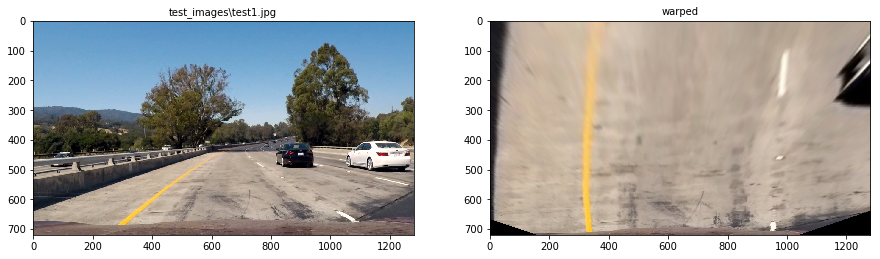

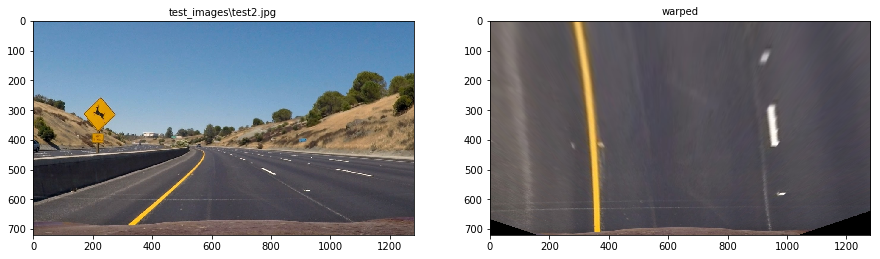

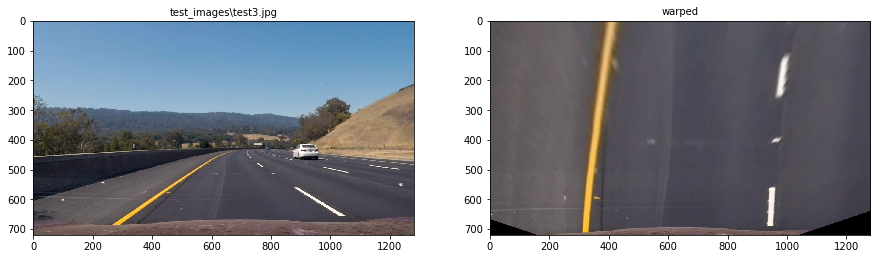

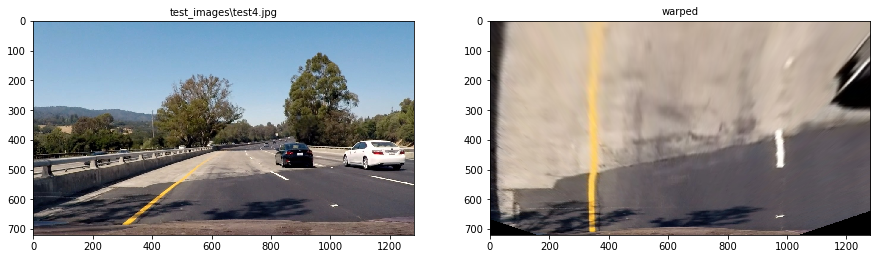

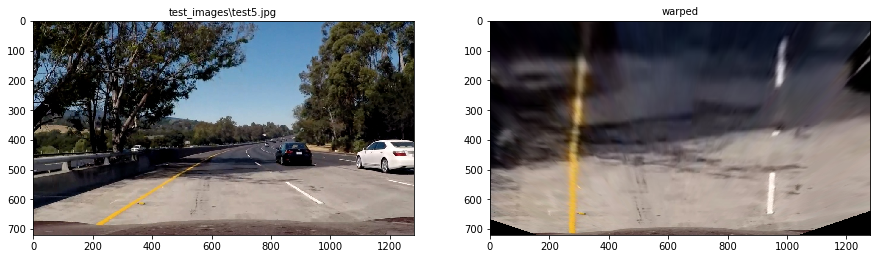

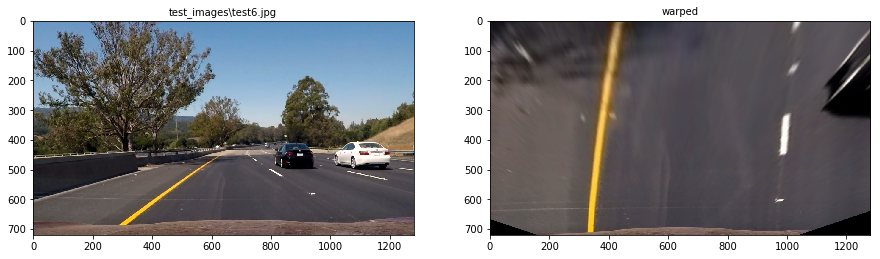

In [6]:
for image in images:
    img = mpimg.imread(image)
    undistimg = undistort(img,objpoints,imgpoints)
    warpedimg = warp(undistimg) 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
    ax1.imshow(img)
    ax1.set_title(image, fontsize=10)
    ax2.imshow(warpedimg)
    ax2.set_title('warped', fontsize=10)

### 4. Use color transforms, gradients, etc., to create a thresholded binary image.

In this step i done a lot of experiment with different color spaces like RGB,HLS and gradients.
After lot of experiment i decided to use S channel (threshold = (170,255)) from HLS color space. Which gives a good result in almost all the images together with sobelx gradient (threshold = (50,100)). It worked good until i got the issue in project_video. In one of the location where tree shadow appears this method failed. 
Then i again experimented with LUV,LAB color space.

    I choose B channel from LAB color space with threshold (0,110). I found that this gives good result in all images even on dark one. But it works well on yellow lane only.
    
    I also choose L channel from LUV color space with threshold (200,255). This worked for white lane.
    
So these two channel is sufficient to find the lane lines from all the images. Then i removed the S channel and sobelx gradient from my code.

#### binary_img()
        function is used to convert a image into a binary threshold image

In [7]:
def binary_img(img,b_thresh=(0,110),l_thresh=(200,255),display=False):
    img = np.copy(img)
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            
    B = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)[:,:,2]
    
    L = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_binary = np.zeros_like(B)
    b_binary[(B >= b_thresh[0]) & (B <= b_thresh[1])] = 1
    
    l_binary = np.zeros_like(L)
    l_binary[(L >= l_thresh[0]) & (L <= l_thresh[1])] = 1
  
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(b_binary == 1) | (l_binary == 1)] = 1
    
    if(display==True):
        f, (org_img, gray_img, b , l, comb) = plt.subplots(1, 5,figsize=(20,10))
        org_img.imshow(img)
        org_img.set_title('Original', fontsize=10)
        gray_img.imshow(gray, cmap='gray')
        gray_img.set_title('gray', fontsize=10)
        b.imshow(B,cmap='gray')
        b.set_title('B channel', fontsize=10)
        l.imshow(L,cmap='gray')
        l.set_title('L channel', fontsize=10)
        comb.imshow(combined_binary, cmap='gray')
        comb.set_title('Combined binary', fontsize=10)
    
    return combined_binary


#### Applying binary_img() function on all the test images

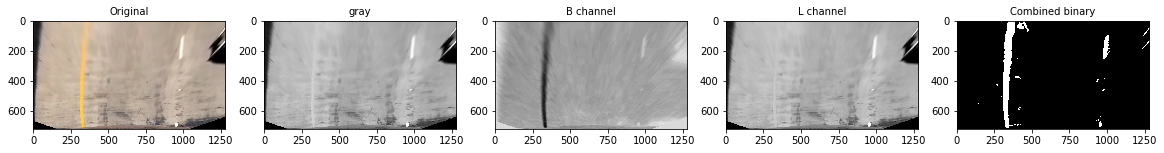

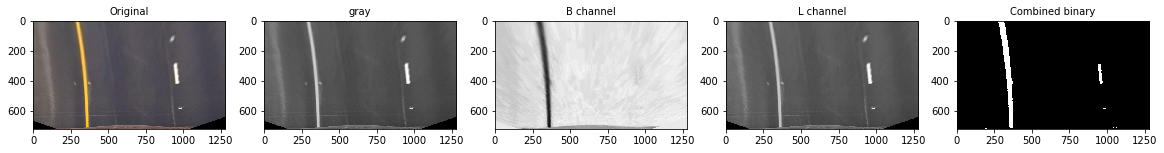

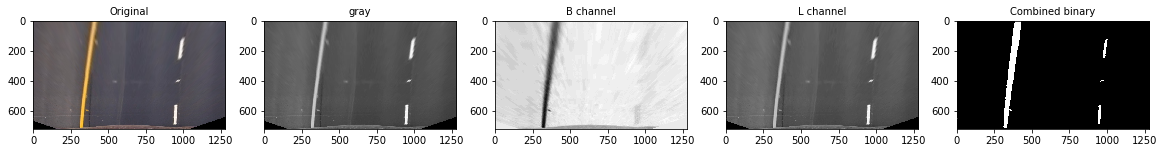

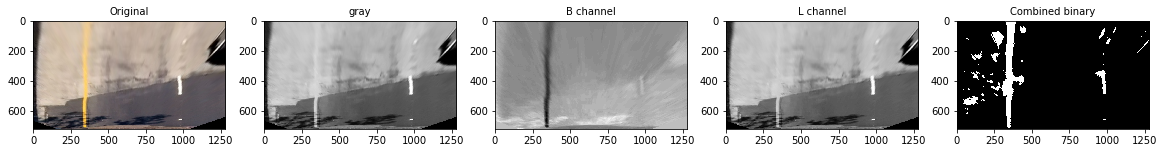

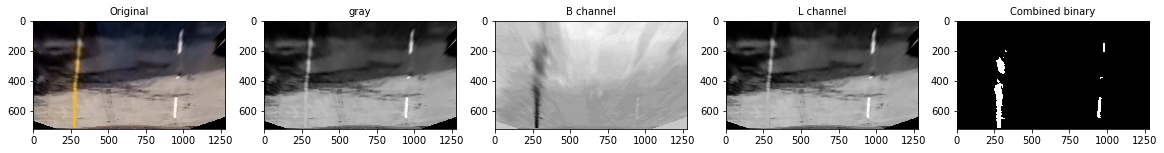

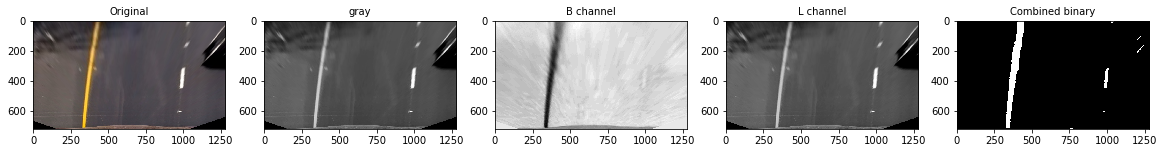

In [8]:
for image in images:
    img = mpimg.imread(image)
    undistimg = undistort(img,objpoints,imgpoints)
    warpedimg = warp(undistimg)
    binaryimg = binary_img(warpedimg,display=True)

#### region_of_interest()
        function is used to apply a filtered mask on binary threshold image and return the image only with lane lines
        
        Here i choose the rectangular mask for the warp binary image.

In [9]:
def region_of_interest(img, vertices):
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


#### Applying region_of_interest() function on all the given test images

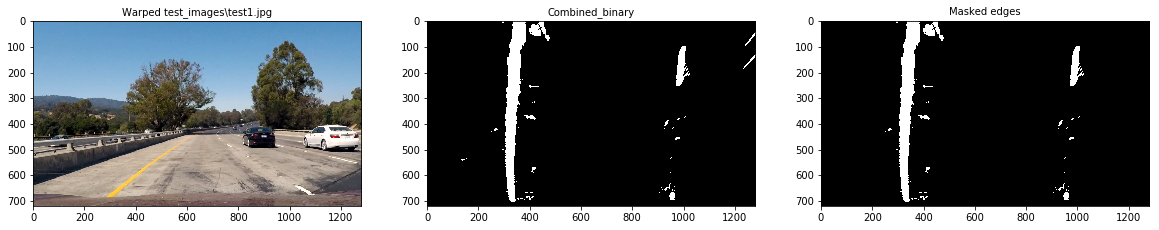

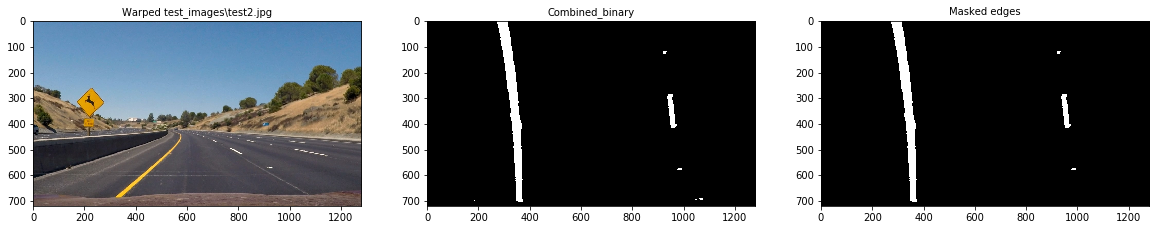

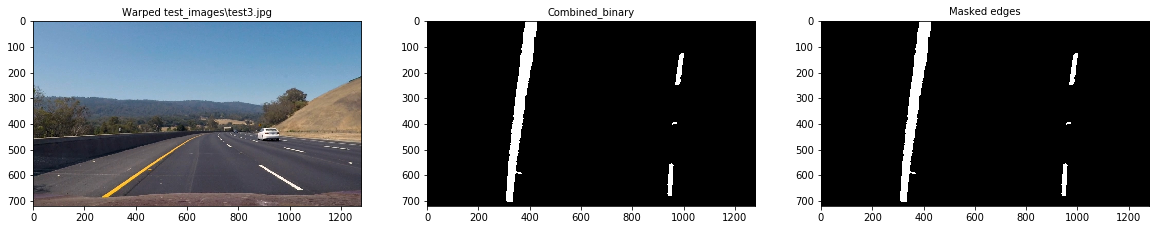

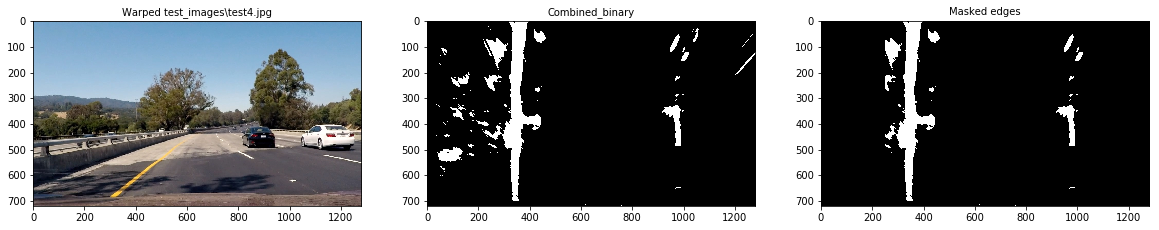

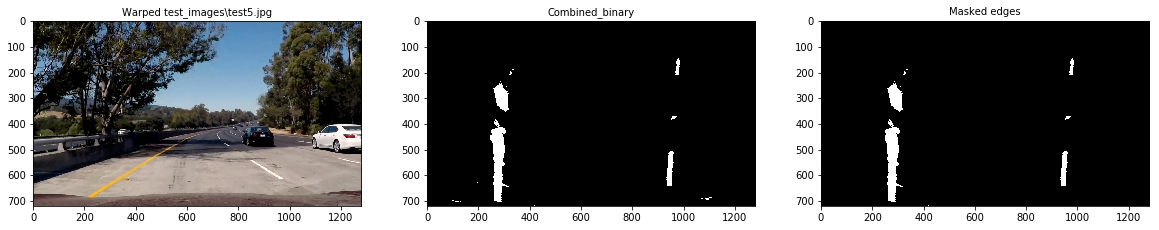

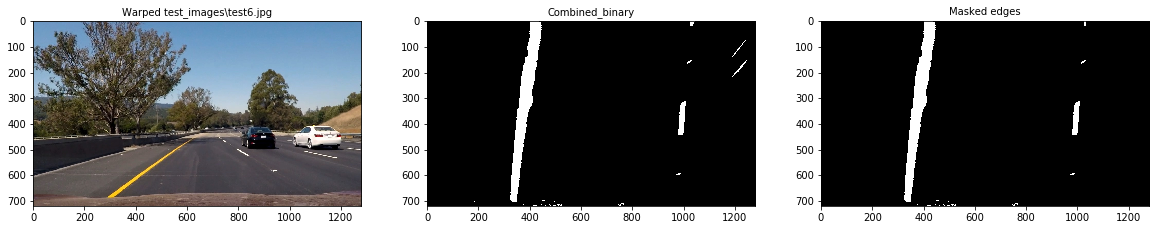

In [10]:
for image in images:
    img = mpimg.imread(image)
    imshape=img.shape
    
    undistimg = undistort(img,objpoints,imgpoints)
    warpedimg = warp(img)
    combined_binary = binary_img(warpedimg)
    masked_edges = region_of_interest(combined_binary,np.array([[(250,imshape[0]),(250,0),(imshape[1]-250,0),(imshape[1]-250,imshape[0])]],dtype=np.int32))
    
    f, (org_img, combined_bin, masked_img) = plt.subplots(1, 3,figsize=(20,10))
    org_img.imshow(img)
    org_img.set_title('Warped ' + image, fontsize=10)
    combined_bin.imshow(combined_binary, cmap='gray')
    combined_bin.set_title('Combined_binary', fontsize=10)
    masked_img.imshow(masked_edges, cmap='gray')
    masked_img.set_title('Masked edges', fontsize=10)

### 5. Detect lane pixels and fit to find the lane boundary.

#### find_lane_pixles()
        function is used to find the lane pixels on warped binary image
 
This function is used to find the left and right lane pixels on warped binary image
Here i am identifying peaks in a histogram of the image to find the location of left and right lane.
then identifying all non zero pixels around histogram peaks using the numpy function `numpy.nonzero()`. And using `numpy.polyfit()` function fitting a polynomial to each lane.

In [11]:
def find_lane_pixles(warped_img, display=False):
    histogram = np.sum(warped_img[warped_img.shape[0]//2:,:],axis=0)
    out_img = np.dstack((warped_img,warped_img,warped_img))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    
    if(display==True):
        plt.plot(histogram)
        plt.plot(leftx_base,0,'.')
        plt.plot(rightx_base,0,'.')
    
    nwindows = 9
    margin = 100
    minipix = 50
    window_height = np.int(warped_img.shape[0]//nwindows)
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = warped_img.shape[0]-(window+1)*window_height
        win_y_high = warped_img.shape[0]-window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minipix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))            
        if len(good_right_inds) > minipix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img



#### fit_polynomial()
        function is used to fit the polynomial after finding the lane pixels

In [12]:
def fit_polynomial(warped_img,display=False):
    leftx, lefty, rightx, righty, out_img = find_lane_pixles(warped_img=warped_img)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    if(display==True):
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    return left_fitx,right_fitx,ploty,out_img

#### Below function shows how the fit_polynomial() function is working

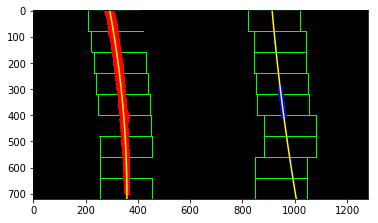

In [13]:
img = mpimg.imread("test_images/test2.jpg")
imshape=img.shape
undistimg = undistort(img,objpoints,imgpoints)    
warpedimg = warp(img)     
combined_binary = binary_img(warpedimg)
masked_binary = region_of_interest(combined_binary,np.array([[(250,imshape[0]),(250,0),(imshape[1]-250,0),(imshape[1]-250,imshape[0])]],dtype=np.int32))

left_fitx,right_fitx,ploty,out_img = fit_polynomial(masked_binary)

plt.imshow(out_img)
plt.plot(left_fitx,ploty,color='yellow')
plt.plot(right_fitx,ploty,color='yellow')

### 6. Determine the curvature of the lane and vehicle position with respect to center.

#### measure_curvature_real()
        function is used to find the left and right curvature of the lane in meter
        
  Here i am calculating radious of curvature in metrs for left and right lane using the following code
    

In [14]:
leftx, lefty, rightx, righty, out_img = find_lane_pixles(masked_binary)


def measure_curvature_real(imshape,leftx,lefty,rightx,righty):
    
    ym_per_pix = 30/imshape[0]
    xm_per_pix = 3.7/imshape[1]

    ploty = np.linspace(0,imshape[0]-1,imshape[0])

    left_fit = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
    right_fit = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
    
    y_eval = np.max(ploty)
    
    left_curvered = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5)/ np.absolute(2*left_fit[0])
    right_curvered = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])
    
    return left_curvered, right_curvered


#### cal_curvature_centeroffset()
        function is used to find the average curvature of the lane and vehicle position with repect to center
        
   Here i am calculating the position of vehicle with respect to center offset.

In [15]:
def cal_curvature_centeroffset(imshape,leftx,lefty,rightx,righty):
    
    xm_per_pix = 3.7/imshape[1]
    
    left_curvered, right_curvered = measure_curvature_real(imshape,leftx,lefty,rightx,righty)
    avg_curve_rad = (left_curvered + right_curvered)/2
    
    #curvature_string = "Radius of curvature: %.2f m" % avg_curve_rad
    
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    height = imshape[0]

    left_fitx = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    right_fitx = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    # compute the offset from the center
    lane_center = (left_fitx + right_fitx)/2
    center_offset_pixels = (imshape[1]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    #offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    return avg_curve_rad,center_offset_mtrs

In [16]:
avg_curve_rad,center_offset_mtrs = cal_curvature_centeroffset(masked_binary.shape,leftx,lefty,rightx,righty)
curvature_string = "Radius of curvature: %.2f m" % avg_curve_rad
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(curvature_string)
print(offset_string)

Radius of curvature: 3833.19 m
Center offset: -0.12 m


### 7. Warp the detected lane boundaries back onto the original image.

#### unwarped_binary_img_with_lane()
        function is used to unwarp the image with detected lane into masked binary image
        After applying this function we will get the masked binary image with detected lane
       

In [17]:
def unwarped_binary_img_with_lane(warped_binary_img,l_fit,r_fit):
    
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped_binary_img).astype(np.uint8)
       
    h,w = warped_binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = unwarp(color_warp)
    
    return unwarped

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#### draw_lane()
        function is used to display the lane boundaries which we got from unwarped_binary_img_with_lane() function on original image
#### put_text_on_image()
        function is used to display the lane curvature and vehicle position on original image
  
Here i am plotting the polynomials on to the warped image, fill the space between the polynomials to highlight the lane and then applying inverse perspective trasformation to unwarp the image from birds eye back to its original perspective. And printing the distance from center and radius of curvature on to the final image.

Text(0.5, 1.0, 'Lane with data')

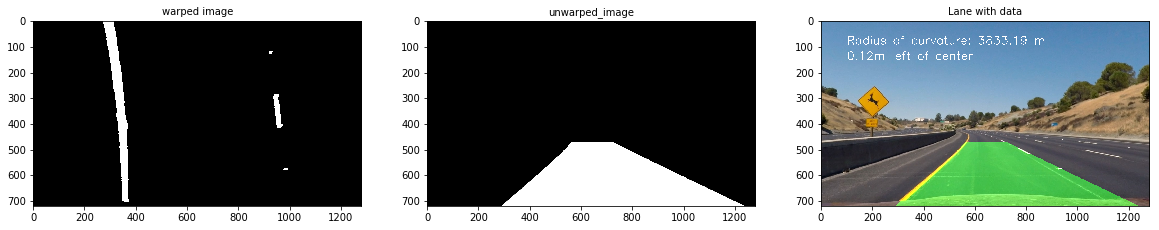

In [18]:
def draw_lane(original_img, unwarped):
    new_img = np.copy(original_img)
    
    un = np.dstack((unwarped,unwarped,unwarped))
    un_img = np.zeros_like(un)
    un_img[:,:,1][unwarped > 0]=255
    
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, un_img, 0.5, 0)
    return result

def put_text_on_image(image, avg_curve_rad, center_offset):
    new_img = np.copy(image)
    height = new_img.shape[0]
    
    curvature_string = 'Radius of curvature: {:05.2f} m'.format(avg_curve_rad)
    
    direction = ''
    if center_offset > 0:
        direction = 'right'
    elif center_offset < 0:
        direction = 'left'
    abs_center = abs(center_offset)
    offset_string = '{:04.2f}'.format(abs_center) + 'm ' + direction + ' of center'
    
    cv2.putText(new_img, curvature_string, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(new_img, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return new_img

leftx, lefty, rightx, righty, out_img = find_lane_pixles(masked_binary)
left_fit = np.polyfit(lefty,leftx,2)
right_fit = np.polyfit(righty,rightx,2)

unwarped_img = unwarped_binary_img_with_lane(masked_binary, left_fit, right_fit)
l_image = draw_lane(undistimg, unwarped_img)
avg_curve_rad,center_offset_mtrs = cal_curvature_centeroffset(masked_binary.shape,leftx,lefty,rightx,righty)
final_lane_image = put_text_on_image(l_image,avg_curve_rad,center_offset_mtrs)

f, (w, u,ex) = plt.subplots(1, 3,figsize=(20,10))
w.imshow(masked_binary,cmap='gray')
w.set_title('warped image', fontsize=10)
u.imshow(unwarped_img, cmap ='gray')
u.set_title('unwarped_image', fontsize=10)
ex.imshow(final_lane_image)
ex.set_title('Lane with data', fontsize=10)

### 9. Pipeline section

#### pipeline()
        function takes the original image and gives the final image with detected lane line and details displayed on the image
        This function has display arugment which display overall pipeline output when the value of the argument is True

In [22]:
def pipeline(imgfile, display=False):
    original_img = mpimg.imread(imgfile)
    imshape=original_img.shape
    
    undistimg = undistort(original_img,objpoints,imgpoints)
    warpedimg = warp(undistimg)
    combined_binary = binary_img(warpedimg)
    masked_binary = region_of_interest(combined_binary,np.array([[(250,imshape[0]),(250,0),(imshape[1]-250,0),(imshape[1]-250,imshape[0])]],dtype=np.int32))
        
    leftx, lefty, rightx, righty, out_img = find_lane_pixles(warped_img=masked_binary)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx,right_fitx,ploty,out_img = fit_polynomial(masked_binary)
    
    unwarped_img = unwarped_binary_img_with_lane(masked_binary, left_fit, right_fit)
    lane_img = draw_lane(undistimg, unwarped_img)
    avg_curve_rad,center_offset_mtrs = cal_curvature_centeroffset(masked_binary.shape,leftx,lefty,rightx,righty)
    final_image = put_text_on_image(lane_img,avg_curve_rad,center_offset_mtrs)
    
    if(display==True):
        f, (org_img, combined_bin, masked_img,fitpoly,unwarped,lane) = plt.subplots(1, 6,figsize=(20,10))
        org_img.imshow(undistimg)
        org_img.set_title(imgfile, fontsize=10)
        combined_bin.imshow(combined_binary, cmap='gray')
        combined_bin.set_title('Combined_binary', fontsize=10)
        masked_img.imshow(masked_binary, cmap='gray')
        masked_img.set_title('Masked edges', fontsize=10)
        fitpoly.imshow(masked_binary,cmap='gray')
        fitpoly.plot(left_fitx, ploty, color = 'yellow')
        fitpoly.plot(right_fitx, ploty, color = 'yellow')
        fitpoly.set_title('Fit poly image',fontsize=10)
        unwarped.imshow(unwarped_img,cmap='gray')
        unwarped.set_title('Unwarped Image',fontsize=10)
        lane.imshow(final_image)
        lane.set_title('Final Image',fontsize=10)
        
    return final_image

#### Applying pipeline() function on all the given test images
#### images during the pipeline process gives the clear picture how the pipeline works

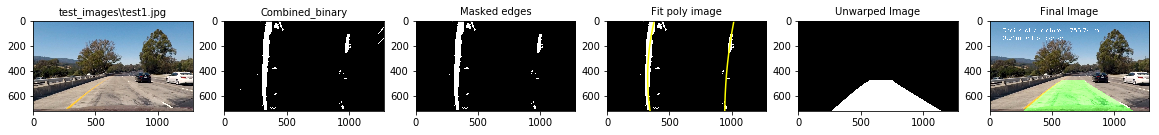

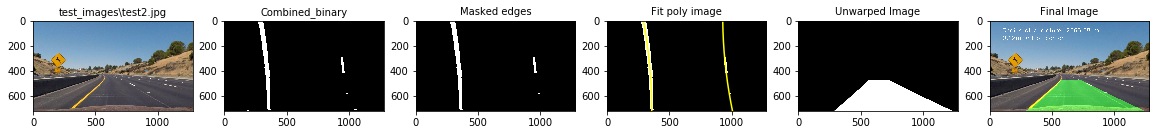

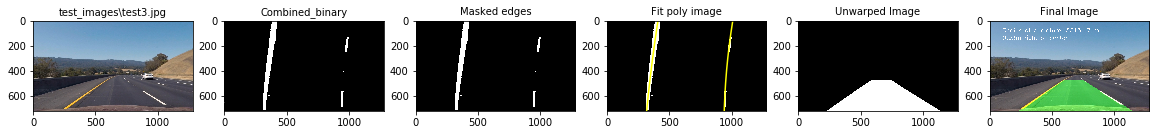

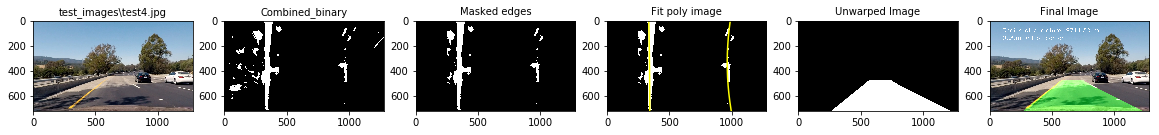

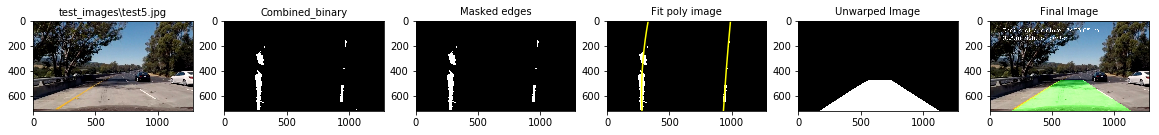

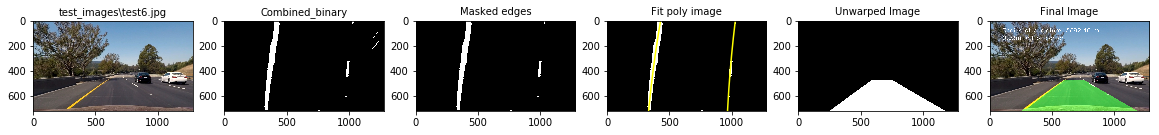

In [23]:
images = glob.glob('test_images/test*.jpg')

for image in images:
    pipeline(image,display=True)

### 10. Video Output
#### process_image()
        function performs the same operation as pipeline() function does
        i am using this function to detect lane on project_video

In [24]:
def process_image(image):
    imshape=image.shape
    undistimg = undistort(image,objpoints,imgpoints)
    warpedimg = warp(undistimg)
    combined_binary = binary_img(warpedimg)
    masked_binary = region_of_interest(combined_binary,np.array([[(250,imshape[0]),(250,0),(imshape[1]-250,0),(imshape[1]-250,imshape[0])]],dtype=np.int32))
        
    leftx, lefty, rightx, righty, out_img = find_lane_pixles(warped_img=masked_binary)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    unwarped_img = unwarped_binary_img_with_lane(masked_binary, left_fit, right_fit)
    lane_img = draw_lane(undistimg, unwarped_img)
    avg_curve_rad,center_offset_mtrs = cal_curvature_centeroffset(masked_binary.shape,leftx,lefty,rightx,righty)
    final_image = put_text_on_image(lane_img,avg_curve_rad,center_offset_mtrs)
    return final_image

#### Importing everything needed to edit/save/watch video clips

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Applying process_image() function on project_video.mp4

In [26]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [27:45<00:01,  1.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 27min 47s


#### Play the video inline

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Discussion
#### For Challenge project issues and improvements
    
    1. Previously i started s channel together with sobelx gradient but that not worked in project video where dark shadow appeared. Then i used B channel from LAB color space and L channel from LUV color space. B channel identified yellow lane and L channel identified white lane. These two channel is sufficient to identified lane on the road.
    2. Normal project pipeline is not working for challange and harder_challenge video. 
    3. The lanes lines in the challenge videos were extremely difficult to detect. They were either too bright or too dull.
    4. For the harder challenge i will try to take perspective transform for smaller section. I tried this but then it failed for normal project video. There is one thing which i never tried yet. When no lane detected consider the previous frame. That may be solve my issue for both video.
    5. The challenge video has a section where the car goes underneath a tunnel. Whole image is in black.